In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
import torch
import matplotlib.pyplot as plt 
import numpy as np
from utils.cnn_duq import CNN_DUQ
from utils.datasets import all_datasets
from utils.cnn_duq import SoftmaxModel as CNN

from utils.resnet import ResNet
from utils.resnet_duq import ResNet_DUQ
from utils.evaluate_ood import get_cifar_svhn_ood, get_auroc_classification

mod='CIFAR10' #['CIFAR10','FMnist']

if mod=='FMnist':
    ds1 = all_datasets["FashionMNIST"]()
    ds2 = all_datasets["MNIST"]()
    input_size = 28
    num_classes = 10
    embedding_size = 256
    learnable_length_scale = False
    gamma = 0.999
    length_scale = 0.1
    d=28
    c=1

    model = CNN_DUQ(
    input_size,
    num_classes,
    embedding_size,
    learnable_length_scale,
    length_scale,
    gamma,
    ).cuda()
    model.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/DUQ_FM_30_FULL.pt'))

    ensemble = [CNN(input_size, num_classes).cuda() for _ in range(5)]
    ensemble = torch.nn.ModuleList(ensemble);
    ensemble.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/FM_5_ensemble_30.pt'))

else:
    ds1 = all_datasets["CIFAR10"]()
    ds2 = all_datasets["SVHN"]()
    length_scale = 0.1
    input_size, num_classes, dataset, test_dataset = ds1
    centroid_size=512
    model_output_size=512 
    gamma = 0.999
    d=32
    c=3

    model = ResNet_DUQ(
            input_size, num_classes, centroid_size, model_output_size, length_scale, gamma
        ).cuda()
    model.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/DUQ_CIFAR_75.pt'))
    ensemble = [
            ResNet(input_size, num_classes).cuda() for _ in range(5)
        ]
    ensemble = torch.nn.ModuleList(ensemble);
    ensemble.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/CIFAR10_5_ensemble.pt'))
    
model.eval()
ensemble.eval()

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/SVHN/train_32x32.mat
Using downloaded and verified file: ./data/SVHN/test_32x32.mat


ModuleList(
  (0): ResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): Identity()
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000


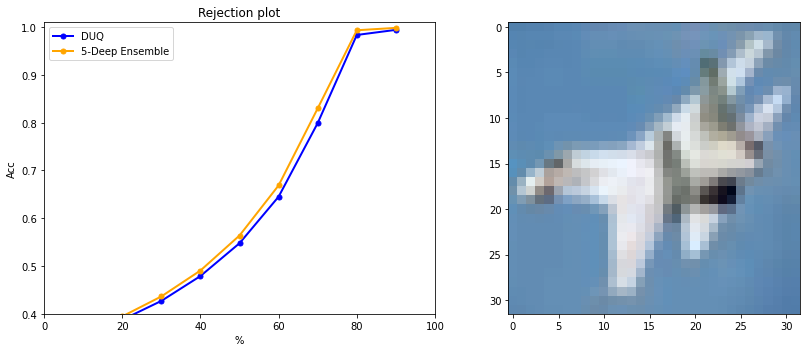

In [13]:
args={'ensemble':5}
input_size, num_classes, _ , test_dataset_n = ds1
_ , _ , _ , test_dataset_o = ds2
er=[0]
fig = plt.figure(figsize=(12,5))


m=test_dataset_n[0][0].max()
rejection_list = [0.1 , 0.2 , 0.3 ,0.4 , 0.5 ,0.6 , 0.7 , 0.8 , 0.9]


for p,e in enumerate(er):
    sample=(test_dataset_n[10][0]).numpy()

    Data = test_dataset_n+test_dataset_o
    num=len(Data)
    b=100
    r=len(Data)
    ls=[]
    for i in range(int(r/b)+1):
        data=[]
        target=[]
        for j in range(0,b):
            cnt=i*b+j
            if(cnt>=r):
              break
            data.append(Data[cnt][0])
            target.append(Data[cnt][1])
        if(len(data)==0):
          break
        data=torch.stack(data)
        target=torch.tensor(target)
        ls.append((data,target))


    target = np.zeros((num,))
    confidence_DUQ = np.zeros((num,))
    pred_DUQ = np.zeros((num,))
    cn=0
    i=0
    for Data,t1 in ls:
      with torch.no_grad():
        _ , output = model(Data.cuda())
        c1,p1= output.max(1)

        for j in range(0,len(Data)):
          confidence_DUQ[cn]=c1[j]
          target[cn]=t1[j]
          pred_DUQ[cn]=p1[j]
          cn+=1
        i+=1
        if(i%20==0):
          print(cn)

    a  = np.concatenate((target.reshape(-1,1),pred_DUQ.reshape(-1,1),confidence_DUQ.reshape(-1,1)) , axis=1)
    x  = a[a[:,-1].argsort()]
    accuracy_DUQ = np.zeros((len(rejection_list),1))
    rejected_DUQ = np.zeros((len(rejection_list),1))
    i=0
    for reject in rejection_list :
      y = x[:][int(reject*num):]
      accuracy_DUQ[i] = ((y[:,0]==y[:,1]).sum())/((1-reject)*num)
      rejected_DUQ[i] = reject*100
      i+=1



    target = np.zeros((num))
    confidence_DE = np.zeros((num,))
    pred_DE = np.zeros((num,))
    i=0
    cn=0
    for Data,t1 in ls:
      with torch.no_grad():
          predictions = torch.stack([model(Data.cuda()) for model in ensemble])
          mean_prediction = torch.mean(predictions.exp(), dim=0)
          p1 = mean_prediction.max(1)[1]
          c1= torch.sum(mean_prediction * torch.log(mean_prediction), dim=1)

          for j in range(0,len(Data)):
              confidence_DE[cn]=c1[j]
              target[cn]=t1[j]
              pred_DE[cn]=p1[j]
              cn+=1
          i+=1
          if(i%20==0):
              print(cn)

    a  = np.concatenate((target.reshape(-1,1),pred_DE.reshape(-1,1),confidence_DE.reshape(-1,1)) , axis=1)
    x  = a[a[:,-1].argsort()]
    accuracy_DE = np.zeros((len(rejection_list),1))
    rejected_DE = np.zeros((len(rejection_list),1))
    i=0
    for reject in rejection_list :
      y = x[:][int(reject*num):]
      accuracy_DE[i] = ((y[:,0]==y[:,1]).sum())/((1-reject)*num) 
      rejected_DE[i] = reject*100
      i+=1



    ax=fig.add_subplot(len(er),2,2*p+1,xlabel='%',ylabel='Acc',title='Rejection plot',xlim=(0,100),ylim=(0.4,1.01))

    ax.plot(rejected_DUQ, accuracy_DUQ, color='blue', linewidth = 2, 
            marker='o', markerfacecolor='blue', markersize=5)
    ax.plot(rejected_DE , accuracy_DE , color='orange', linewidth = 2, 
            marker='o', markerfacecolor='orange', markersize=5 )
    ax.legend(['DUQ','5-Deep Ensemble'])

    ax=fig.add_subplot(len(er),2,2*p+2)
    sample-=sample.min()   
    sample/=sample.max()
    if(sample.shape[0]>1):
      sample=sample.transpose((1,2,0))
    else:
      sample=sample.reshape(d,d)
    ax.imshow(sample)
 
fig.tight_layout()
plt.show()
